## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import os
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS
#from helper import *

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [11]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
#vers = 'v6_Pedro_newDNN_skim'
vers = 'v6_Pedro_newDNN'
#vers = 'v6'
data_label = {}
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
#plot_folder = "v6_ME1_newDNN_skim"
plot_folder = "v6_ME1_newDNN"
lumi = 23.02*1000
xsec = 48.

if data_year == 2022:
    fpath['data'] = data_path + 'data.root'#'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'mc.root'#'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
    data_label['data'] = 'Data'
    data_label['signal'] = 'Signal'
    
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    data_weight = np.zeros(100)
    signal_gen_weight = np.zeros(100)
    if k=='signal':
        signal_gen_weight = tree[k]["weight"].array()
        #print(NEvents[k]*48.58)
        #print(NEvents[k])
    else:
        data_weight = tree[k]["weight"].array()

signal_gen_yield = np.sum(signal_gen_weight)*lumi/NEvents['signal']*48.58
data_all_yield = np.sum(data_weight)

print(signal_gen_weight.sum()*lumi)
print( signal_gen_weight.sum()*lumi/NEvents['signal']*48.58)
#print(data_all_yield)

for k, T in tree.items():
    branch_names = T.keys()
    print(k, NEvents[k])

987184983920.0
1118334.9661248096
data 15508012.0
signal 42882900.0


In [5]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
all_weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}
cscClusterNStation = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}
cscClusterDphi = {}
cscClusterDNN = {}

tr_cscClusterMuonVetoPt = {}
tr_cscClusterJetVetoPt = {}
tr_cscClusterPhi = {}
tr_cscClusterEta = {}
tr_cscClusterEta2 = {}
tr_cscClusterEta3 = {}
tr_cscClusterR = {}
tr_cscClusterZ = {}
tr_cscClusterSize = {}
tr_cscClusterSize2 = {}
tr_cscClusterSize3 = {}
tr_cscClusterTimeSpread = {}
tr_cscClusterTime = {}
tr_cscClusterTime2 = {}
tr_cscClusterTime3 = {}
tr_cscClusterMet_dPhi = {}
tr_cscClusterNStation = {}
tr_cscClusterAvgStation = {}
tr_cscClusterMaxStation = {}
tr_cscClusterDphi = {}
tr_cscClusterDNN = {}

nCscClusters = {}

#cscClusterNRechitMinus11 = {}
#cscClusterNRechitPlus11 = {}
#cscClusterNRechitMinus12 = {}
#cscClusterNRechitPlus12 = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}

ME11_veto = {}
ME12_veto = {}
ME1_veto = {}
MB1_veto = {}

#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#L1 plateau - global, non positional
cl_in_ME11 = {}
cl_in_ME12 = {}
cl_in_ME13 = {}
cl_in_ME21 = {}
cl_in_ME22 = {}
cl_in_ME31 = {}
cl_in_ME32 = {}
cl_in_ME41 = {}
cl_in_ME42 = {}

cl_in_plateau_ME11 = {}
cl_in_plateau_ME12 = {}
cl_in_plateau_ME13 = {}
cl_in_plateau_ME21 = {}
cl_in_plateau_ME22 = {}
cl_in_plateau_ME31 = {}
cl_in_plateau_ME32 = {}
cl_in_plateau_ME41 = {}
cl_in_plateau_ME42 = {}
cl_in_plateau = {}



#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [6]:
category = 0#-1#0
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = True
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = True
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = True
do_csc_in_time_cut = True
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

#plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd"
#plot_string+= "_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [7]:
for a in branch_names:
    if "DNN" in str(a):
        print(a)
    #if "dtRechitClusterMaxStationRatio" in str(a):
    #    print(a)
    #if "atio" in str(a):
    #    print(a)
    #if 'csc' in str(a):
    #    print(a)

b'dtRechitClusterDNN'
b'cscRechitClusterDNN'


In [8]:
#def iterative_numpy(a):
#    mask = a > -999.
#    out = np.array([ a[i,mask[i]] for i xrange(a.shape[0]) ])
#    return out

In [9]:
n_1CSC = {}
n_2CSC = {}

n_1CSC_ME1 = {}
n_1CSC_ME1_old = {}
n_2CSC_ME1 = {}
n_2CSC_ME1_old = {}

n_1CSC_ME1_plateau = {}
n_2CSC_ME1_plateau = {}

n_1CSC_ME1_plateau_0lep = {}
n_2CSC_ME1_plateau_0lep = {}

n_2CSC_ME1_plateau_0lep_hlt = {}
n_2CSC_ME1_plateau_0lep_hlt_dphi = {}

for k, T in tree.items():
    
    print("\n")
    print(k)
    tree_keys.append(k)
 
    #ev_num = (T.array('evtNum')<1000000000000000000000000000000000000000000000000000000000000000000000000000000000000)
    ev_num = (T.array('evtNum')>-1)
    #ev_num = (T.array('evtNum')<5000)
    
    pre_sel_csccluster = (T.array('cscRechitClusterSize') >= 0)[ev_num]
    n_pre_cl = pre_sel_csccluster.sum()

    n_1CSC[k] = T.array('weight')[ev_num][n_pre_cl>0].sum()
    print("n_at_least_1_cluster[k]: ", n_1CSC[k])
    n_2CSC[k] = T.array('weight')[ev_num][n_pre_cl>1].sum()

    ###############################################
    #ME1 veto and L1/HLT plateau on trigger cluster
    ME11_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[ev_num]==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[ev_num]==0
    )  

    ME12_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')[ev_num]==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')[ev_num]==0
    )      

    ME1_veto[k] = ( ME11_veto[k] & ME12_veto[k] )
    

    
    #Old way: ME1_veto applied to all clusters
    sel_csccluster_old = np.logical_and(pre_sel_csccluster,
                                    np.logical_and(ME11_veto[k],ME12_veto[k])
                                   )
    
    n_old_cl = sel_csccluster_old.sum()
    
    n_1CSC_ME1_old[k] = T.array('weight')[ev_num][n_old_cl>0].sum()
    n_2CSC_ME1_old[k] = T.array('weight')[ev_num][n_old_cl>1].sum()
        
    #tmp variables to identify trigger cluster
    tmp_cscClusterR = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][:,:]**2 )
    tmp_cscClusterZ = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][:,:]
    tmp_cscClusterSize =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][:,:]
    
    cl_in_ME11[k] = (tmp_cscClusterR>100)&(tmp_cscClusterR<275) &(abs(tmp_cscClusterZ)>580)&(abs(tmp_cscClusterZ)<632) 
    cl_in_ME12[k] = (tmp_cscClusterR>275)&(tmp_cscClusterR<465) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)
    cl_in_ME13[k] = (tmp_cscClusterR>505)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)

    cl_in_ME21[k] = (tmp_cscClusterR>139)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>789)&(abs(tmp_cscClusterZ)<850)
    cl_in_ME22[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>791)&(abs(tmp_cscClusterZ)<850)

    cl_in_ME31[k] = (tmp_cscClusterR>160)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>915)&(abs(tmp_cscClusterZ)<970)
    cl_in_ME32[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>911)&(abs(tmp_cscClusterZ)<970)

    cl_in_ME41[k] = (tmp_cscClusterR>178)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    cl_in_ME42[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    
    cl_in_plateau_ME11[k] = cl_in_ME11[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME21[k] = cl_in_ME21[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME31[k] = cl_in_ME31[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME41[k] = cl_in_ME41[k] & (tmp_cscClusterSize>=500)

    cl_in_plateau_ME12[k] = cl_in_ME12[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME13[k] = cl_in_ME13[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME22[k] = cl_in_ME22[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME32[k] = cl_in_ME32[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME42[k] = cl_in_ME42[k] & (tmp_cscClusterSize>=200)    
    
    cl_in_plateau[k] = cl_in_plateau_ME11[k] | cl_in_plateau_ME12[k] | cl_in_plateau_ME13[k] | cl_in_plateau_ME21[k] | cl_in_plateau_ME22[k] | cl_in_plateau_ME31[k] | cl_in_plateau_ME32[k] | cl_in_plateau_ME41[k] | cl_in_plateau_ME42[k]

    #event level selection: at least 1 cluster fulfilling the condition
    sel_ev_new_me1 = (ME1_veto[k]).any()==True
    sel_ev_new_me1_pl = (ME1_veto[k] & cl_in_plateau[k]).any()==True
    
    #now counting the clusters
    sel_csccluster_new_me1 = sel_csccluster_old  & sel_ev_new_me1
    sel_csccluster_new_me1_pl = sel_csccluster_old  & sel_ev_new_me1_pl
    
    n_new_cl_me1 = sel_csccluster_new_me1.sum()
    n_new_cl_me1_pl = sel_csccluster_new_me1_pl.sum()
    
   
    n_1CSC_ME1[k] = T.array('weight')[ev_num][n_new_cl_me1>0].sum()
    n_2CSC_ME1[k] = T.array('weight')[ev_num][n_new_cl_me1>1].sum()
    
    n_1CSC_ME1_plateau[k] = T.array('weight')[ev_num][n_new_cl_me1_pl>0].sum()
    n_2CSC_ME1_plateau[k] = T.array('weight')[ev_num][n_new_cl_me1_pl>1].sum()    
    #From now: ask at least 1 cluster!
    
    #Remove trigger clusters
    tr_cluster_mask = (ME1_veto[k] & cl_in_plateau[k] )#[ n_new_cl_me1_pl>1 ]
    #no cuts on multiplicity will raise exceptions here
    tag_tr_cluster = tmp_cscClusterSize[ tr_cluster_mask==True ][ n_new_cl_me1_pl>0 ][:,0]
    new_tmp_cscClusterSize = tmp_cscClusterSize[ n_new_cl_me1_pl>0 ]
    tag_tr_cluster_mask = (new_tmp_cscClusterSize == tag_tr_cluster)

    sel_csccluster = sel_csccluster_new_me1_pl[ n_new_cl_me1_pl>0 ] & (tag_tr_cluster_mask==False)
    sel_tr_csccluster = sel_csccluster_new_me1_pl[ n_new_cl_me1_pl>0 ] & (tag_tr_cluster_mask==True)

    ####### Selections only to non-trigger clusters

    ### Jet and muon veto
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[ev_num][ n_new_cl_me1_pl>0 ]<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt')[ev_num][ n_new_cl_me1_pl>0 ] >= 30, T.array('cscRechitClusterMuonVetoGlobal')[ev_num][ n_new_cl_me1_pl>0 ]))

    if do_jet_veto:
        sel_csccluster = sel_csccluster & jet_veto_csc
    if do_muon_veto:
        sel_csccluster = sel_csccluster & muon_veto_csc

    ### Time spread cut
    if do_csc_time_spread_cut:
        #Run2:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_new_cl_me1_pl>0 ]<20)
        #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_new_cl_me1_pl>0 ]<30)
    
    ### Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_new_cl_me1_pl>0 ]< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_new_cl_me1_pl>0 ] > -5))    
        
        
        
    sel_ev_0lep = (T.array('nLeptons')[ev_num][ n_new_cl_me1_pl>0 ] == 0)
    sel_ev[k] = sel_ev_0lep

    n_1CSC_ME1_plateau_0lep[k] = T.array('weight')[ev_num][ n_new_cl_me1_pl>0 ][sel_ev_0lep].sum()

    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()[ev_num][ n_new_cl_me1_pl>0 ]    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    n_2CSC_ME1_plateau_0lep[k] = T.array('weight')[ev_num][ n_new_cl_me1_pl>1][ (T.array('nLeptons')[ev_num][ n_new_cl_me1_pl>1 ] == 0) ].sum()   
    
    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50#[ev_num][ n_new_cl_me1_pl>0 ]
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose#[ev_num][ n_new_cl_me1_pl>0 ]
     
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], (T.array('runNum')[ev_num][ n_new_cl_me1_pl>0 ] >=360019))

    
    if category == 1:
        #sel_csccluster includes ONLY the non trigger clusters!!!
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    #elif category == 2:      
    #    sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 0)
    #    sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
    #    hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    n_2CSC_ME1_plateau_0lep_hlt[k] = T.array('weight')[ev_num][ n_new_cl_me1_pl>0 ][ sel_ev[k] ].sum()
    
    ########### BRANCHES ############

    #sel_dtcluster = sel_dtcluster & sel_ev[k]
    sel_csccluster = sel_csccluster & sel_ev[k]
    sel_tr_csccluster = sel_tr_csccluster & sel_ev[k]
       
    #dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
    #dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[sel_ev_tmp][sel_dtcluster][ sel_ev[k] ]
        
    #cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    #cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster]**2 )[ sel_ev[k] ]
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[ev_num][ n_new_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    
    #convert numpy.darrays to awkward
    print("start awkward")
    #pre_DNN_padded = awkward.fromiter(T.array('cscRechitCluster' + cluster_index + 'DNN')[ev_num][ n_new_cl_me1_pl>0 ])
    pre_DNN_padded = awkward.JaggedArray.fromregular(T.array('cscRechitCluster' + cluster_index + 'DNN')[ev_num][ n_new_cl_me1_pl>0 ])
    
    #mask invalid DNN scores of zero padded stuff
    print("done!")
    pre_DNN_padded_mask = pre_DNN_padded > -.999
    DNN_padded = pre_DNN_padded[pre_DNN_padded_mask]
    #apply selections
    cscClusterDNN[k] = DNN_padded[sel_csccluster][ sel_ev[k] ]
    nCscClusters[k] = sel_csccluster[ sel_ev[k] ].sum()#[sel_ev[k]]
    
    tr_cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster]**2 )[ sel_ev[k] ]
    tr_cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[ev_num][ n_new_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterDNN[k] = DNN_padded[sel_tr_csccluster][ sel_ev[k] ]    
    
    weight[k] = T.array('weight')[ev_num][ n_new_cl_me1_pl>0 ][ sel_ev[k] ]  
    all_weight[k] = T.array('weight')
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - tr_cscClusterEta[k][:,0].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), tr_cscClusterEta[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - tr_cscClusterTime[k][:,0].flatten() )  
    n_2CSC_ME1_plateau_0lep_hlt_dphi[k] = T.array('weight')[ev_num][ n_new_cl_me1_pl>0 ][ sel_ev[k]][(  np.abs(dPhi_csc_csc[k])>1.8 ) ].sum()   



data
n_at_least_1_cluster[k]:  15066429.0
start awkward
done!


signal
n_at_least_1_cluster[k]:  8705218.0
start awkward
done!


In [10]:
#print(tree_keys)
for k in list(dict.fromkeys(tree_keys)):
    
    if k=="signal":
        L = lumi/NEvents['signal']*48.58
        den = signal_gen_yield
    else:
        L = 1
        den = np.sum(all_weight[k])
    print("\n")
    print(k)
    print("\n")
    print("Selection \t\t\t Yield \t\t Eff.(%)")
    print("%s\t\t\t\t %.2f\t %.2f" % ("No cuts",(np.sum(all_weight[k])*L) , (100*np.sum(all_weight[k])*L)/den))

    print("%s\t\t\t\t %.2f\t %.3f" % 
      (">=1 CSC", 
       (np.sum(n_1CSC[k])*L) , 
       (100*np.sum(n_1CSC[k])*L)/den)
     )
    print("%s\t\t %.2f\t %.3f" % 
      (">=1 CSC (ME1 old)", 
       (np.sum(n_1CSC_ME1_old[k])*L) , 
       (100*np.sum(n_1CSC_ME1_old[k])*L)/den)
     )
    print("%s\t\t\t %.2f\t %.3f" % 
      (">=1 CSC (ME1)", 
       (np.sum(n_1CSC_ME1[k])*L) , 
       (100*np.sum(n_1CSC_ME1[k])*L)/den)
     )

    print("%s\t\t %.2f\t %.3f" % 
      (">=1 CSC (ME1+L1)", 
       (np.sum(n_1CSC_ME1_plateau[k])*L) , 
       (100*np.sum(n_1CSC_ME1_plateau[k])*L)/den)
     )
    
    print("%s\t\t %.2f\t %.3f" % 
      (">=1 CSC (ME1+L1+0L)", 
       (np.sum(n_1CSC_ME1_plateau_0lep[k])*L) , 
       (100*np.sum(n_1CSC_ME1_plateau_0lep[k])*L)/den)
     )
    print("************************************************************")
    print("%s\t\t %.2f\t %.3f" % 
      (">=2 CSC (ME1 old)", 
       (np.sum(n_2CSC_ME1_old[k])*L) , 
       (100*np.sum(n_2CSC_ME1_old[k])*L)/den)
     )
    print("%s\t\t\t %.2f\t %.3f" % 
      (">=2 CSC (ME1)", 
       (np.sum(n_2CSC_ME1[k])*L) , 
       (100*np.sum(n_2CSC_ME1[k])*L)/den)
     )
    
    print("%s\t\t %.2f\t %.3f" % 
      (">=2 CSC (ME1+L1)", 
       (np.sum(n_2CSC_ME1_plateau[k])*L) , 
       (100*np.sum(n_2CSC_ME1_plateau[k])*L)/den)
     )


    print("%s\t\t %.2f\t %.3f" % 
      (">=2 CSC (ME1+L1+0L)", 
       (np.sum(n_2CSC_ME1_plateau_0lep[k])*L) , 
       (100*np.sum(n_2CSC_ME1_plateau_0lep[k])*L)/den)
     )
    print("%s\t\t %.2f\t %.3f" % 
      (">=2 CSC (ME1+L1+0L+HLT)", 
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt[k])*L) , 
       (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt[k])*L)/den)
     )
    
    print("%s\t %.2f\t %.3f" % 
      (">=2 CSC (ME1+L1+0L+HLT+dPhi)", 
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[k])*L) , 
       (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[k])*L)/den)
     )
    




data


Selection 			 Yield 		 Eff.(%)
No cuts				 15508012.00	 100.00
>=1 CSC				 15066429.00	 97.153
>=1 CSC (ME1 old)		 13205931.00	 85.156
>=1 CSC (ME1)			 13205931.00	 85.156
>=1 CSC (ME1+L1)		 8321409.00	 53.659
>=1 CSC (ME1+L1+0L)		 8262784.00	 53.281
************************************************************
>=2 CSC (ME1 old)		 143151.00	 0.923
>=2 CSC (ME1)			 143151.00	 0.923
>=2 CSC (ME1+L1)		 86693.00	 0.559
>=2 CSC (ME1+L1+0L)		 86133.00	 0.555
>=2 CSC (ME1+L1+0L+HLT)		 9006.00	 0.058
>=2 CSC (ME1+L1+0L+HLT+dPhi)	 1302.00	 0.008


signal


Selection 			 Yield 		 Eff.(%)
No cuts				 1118334.97	 100.00
>=1 CSC				 227016.98	 20.300
>=1 CSC (ME1 old)		 100069.30	 8.948
>=1 CSC (ME1)			 100069.30	 8.948
>=1 CSC (ME1+L1)		 38096.93	 3.407
>=1 CSC (ME1+L1+0L)		 37861.34	 3.386
************************************************************
>=2 CSC (ME1 old)		 2580.67	 0.231
>=2 CSC (ME1)			 2580.67	 0.231
>=2 CSC (ME1+L1)		 1547.68	 0.138
>=2 CSC (ME1+L1+0L)		 1537.41	 0.137
>=2

In [9]:
colors = {}
colors['data'] = 1
colors['signal'] = 2

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 3 1 1 1 1 1 3
 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 3 1 1 3 1 2 1 1 1
 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 4 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 3 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 2 1 1 1 1 3 1 1

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[1 1 1 2 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 2 3 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 3 1 1 1 1 1 1 3 1 1 1 1 2 1 1
 1 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1
 1 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 3 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 2 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 1 3
 1 1 3 1 1 1 1 1 1 3

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[2.2621326  2.252377   2.076101   2.0387745  1.3091787  2.0162723
 2.0923285  2.1552935  1.2757949  2.1933486  1.232536   2.2320511
 2.2417388  2.174534   2.3037276  1.6952006  1.1991864  1.280554
 0.9657953  1.3934138  1.4699591  2.2181394  1.4542629  1.9596549
 1.3424637  1.5911105  1.2800478  2.2585673  2.193576   1.477185
 2.1245203  2.0156834  2.133035   1.3203689  1.1254869  1.4637275
 2.3008223  1.2251563  2.1614454  1.3689722  1.1578277  2.3388205
 1.4085664  1.9972982  2.0272667  1.9273127  2.1949158  2.220593
 1.49734    1.4127189  2.2420938  1.8579242  2.3269267  1.7920749
 1.3278073  1.3043275  1.3972361  2.1747308  1.5104094  1.2049718
 2.0701115  2.222644   1.9734532  2.1050606  2.21264    1.911318
 1.4489232  1.4195412  1.3809106  1.1238766  1.8889422  2.3770227
 1.8823777  2.2028897  2.1964457  1.9778632  2.2988522  1.4388889
 2.2201912  2.1850564  2.3439584  2.2791474  1.6201867  1.9025084
 2.3123038  2.3697457  2.0425541  2.0543761  2.134076   1.9913459
 1.975539

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[-1.64007843e+00 -2.10081983e+00  2.99864173e+00  2.99220824e+00
 -9.42736194e-02 -9.01759684e-01 -2.81708807e-01  2.53033376e+00
 -2.71796679e+00  1.66033521e-01 -1.54649901e+00  2.78692293e+00
  2.66092420e+00 -2.95824099e+00 -2.62398744e+00  1.72125471e+00
 -3.10910654e+00  2.17063761e+00 -2.84131360e+00 -2.79972410e+00
  2.60807157e+00 -1.12047446e+00  3.76139671e-01  2.30513167e+00
 -3.29925746e-01  7.80124247e-01 -2.73203945e+00  2.66584158e+00
  1.45789683e+00  5.84097624e-01 -1.99953878e+00 -2.12256598e+00
 -2.45997953e+00  5.00315130e-01  2.56957650e+00  2.94566560e+00
  2.89557314e+00  3.54165643e-01  2.79879928e+00 -3.09075952e+00
  2.74687076e+00  8.44141841e-02  2.88469481e+00  1.14975715e+00
  1.06206322e+00  1.69638264e+00  2.59705877e+00 -4.92527820e-02
  1.74419427e+00 -1.59487709e-01 -3.02317739e+00  1.48267627e+00
  2.25407171e+00  1.39244580e+00 -3.51897299e-01 -1.45418465e+00
 -2.74152207e+00  2.14223075e+00  2.46526718e+00 -8.06356311e-01
  2.32322693e+00 -9.

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[420.76202 569.30676 520.31726 485.48145 242.63063 493.9053  284.6112
 246.61943 203.1551  461.8872  493.8762  246.16873 208.2666  271.1302
 554.7457  597.40753 514.5865  508.37573 566.5382  501.13644 200.66574
 412.86157 278.18582 592.2519  563.6936  271.97668 268.61508 480.35104
 524.0581  438.42468 316.46362 633.08344 549.1429  272.51276 525.2383
 267.64102 462.8913  491.78525 486.18542 232.03104 444.1672  263.9344
 571.9261  253.00519 466.33713 234.89862 190.18193 460.25977 272.5585
 590.9869  430.17624 425.26978 453.92276 483.93185 556.344   530.7479
 263.72406 416.6031  528.3938  526.92773 359.7354  545.02734 408.89313
 304.3303  486.33868 510.4297  622.69257 251.95111 513.60974 253.28973
 224.50717 221.2608  589.4402  456.69373 510.94434 240.68088 290.04858
 429.3238  424.03983 506.37473 416.45923 554.9372  601.8115  251.10321
 245.86642 444.49316 212.24695 271.30344 425.63898 243.01643 238.61835
 456.475   626.4994  413.0127  409.22424 239.16867 512.8557  593.0191
 510.851

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[1.6192875 2.243729  2.1721005 2.2341266 1.5629131 1.8069304 2.31035
 1.2723004 1.590433  2.1766908 1.8405744 1.2064583 1.7091662 1.5962805
 2.029949  1.421103  2.4465346 2.1746202 1.6868677 1.8242955 1.7511607
 1.7549355 1.2948446 2.45526   1.5888848 1.4963735 1.3818805 1.6924344
 2.2387142 1.439435  1.7003621 2.4489908 2.1742842 1.4845496 1.604358
 1.4937824 1.708692  1.9848586 1.8865337 1.4894385 1.4811096 2.4775336
 1.5034426 1.4748546 1.9218943 1.5850859 2.4909601 2.4361846 2.456838
 2.350473  1.6860248 1.8107288 1.7342286 2.0813973 1.9709369 1.6312824
 2.066027  1.4760914 1.2584379 1.4883662 1.5938206 1.6468515 1.5402417
 1.9234673 1.6345984 2.0433934 1.5978283 2.3903847 1.3896438 1.7174491
 1.2585531 1.8078703 2.256658  1.9341156 2.5128195 1.4132669 1.7253592
 1.9080027 1.7885817 1.4384313 2.2041938 2.4883547 1.3593669 1.5311506
 1.3316766 1.7687829 1.3177592 1.2275946 1.7557731 1.3606317 2.46466
 1.5102258 1.3971334 2.4241102 1.477513  1.3777484 1.6493418 2.015367
 2.06348

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[1.0433228  2.424722   1.9159448  0.7837087  1.6429403  2.8443205
 0.24114776 1.29902    0.02616048 0.4760704  0.26319677 1.8609143
 1.517993   1.5568004  1.7443193  0.90342367 0.33787757 1.0860298
 2.3104603  1.2129743  0.09314132 2.8509057  1.1067439  1.3142434
 1.249035   2.5447695  0.01372147 2.8837705  1.5178491  2.1058993
 3.070685   1.1007334  0.85474503 1.8192551  0.03530717 0.6149021
 0.5331558  0.9500452  1.8574368  2.7419791  0.3383602  0.19174528
 0.99882007 3.1105328  2.7079182  1.329449   2.6857069  2.31571
 0.03487039 1.294556   2.6459138  0.30470943 1.1267122  0.6207035
 0.09878242 0.14848873 2.3979363  0.6049107  2.010909   1.3923872
 0.578423   0.34061617 1.6570303  1.7294797  2.9803169  1.0028213
 3.0559373  1.9855912  1.0945866  2.8239038  2.8153977  0.25300455
 1.1622382  1.5822853  2.314903   0.3934688  2.4921768  1.7192494
 1.0939038  0.81347346 1.7182056  1.543154   0.04798675 0.5464282
 1.3560237  2.3285472  2.1389778  0.6567689  2.7462783  0.12364745
 2.5

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[ 218  258  353  229 2227  214  527  803  916  221  263 1729 1730 1230
  216  202  225  210  210  358 1277  233  750  230  202  539  679  258
  208  880 1470  256  233 1530  615 1265  321 1945  297  765  201  510
  230  501  244 1965  601  209  525  289  260  207  210  269  346  892
  513  202  528  281  318  225  250  842  200  233  284  673 3175  583
 1121  515  248  300  208 3588  721  880  215  216  211  311  318 4042
 1376  228  544  532  230 1447 1349  997  227  289  575  503  201  678
  209  331  288  242  393  212  790  436 2243  259  218  260  312  375
 1285  252  650  254  201  264  443  240  206  341  573  519  631  682
  209 1041  213  208  911  366 1373  295  209 1002  239  296  335  225
  259  325  547  514  286  427  355  259  216  200  827  235  295  503
 5409 1466  476 1928  206  273 4140  223  221  303  265  478  267 3401
  275  341  548  267  206  226  222  227  649  222  305 1589 1728  213
  320  436  222  552  244  335  282  687  238  229  234  357  243  215
 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

data
[12.038403  16.884743  17.358389  12.014587  17.662405   8.943701
  6.3760166 15.163812  15.506328  14.623073  13.8919735 11.261017
 17.156609  17.541233  13.065981  13.302079  14.612206  12.399175
  8.775987   7.938585  15.05009   14.145179  16.269745  13.65181
 10.847475  17.086601  16.857012  15.978151  10.057768  14.315134
 17.071745   8.852262  15.9501    13.6705885 11.63724   10.216945
  9.847326  12.412334   8.041883  17.12932   19.26352   11.610342
 14.912439  11.652527  11.236127  15.516629   6.972524  14.172922
  8.805673  15.785819   8.376162  15.491664  18.460308   9.551911
 12.404592   9.02171   17.978992  15.1535635 16.16774   12.5882435
 12.323563  14.346259   9.889868   9.026147   9.975755  12.103801
 18.828207   9.341153  10.310187  10.153217  12.473062  19.673782
 11.478233  17.331757  19.51079   15.425243  16.703522  16.221212
 11.524867  12.9012    16.603058  13.75743   12.075018  16.039202
 11.808077  12.068903  12.709469  15.480466  10.247122  10.890418
 10.9

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6_ME1_old/CscClusterNStation.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6_ME1_old/CscClusterNStation.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6_ME1_old/FirstCscClusterNStation.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6_ME1_old/FirstCscClusterNStation.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v6_ME1_old/CscClusterAvgStation.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6_ME1_old/CscClusterAvgStation.png has been created
Warning in <TCanvas::Co

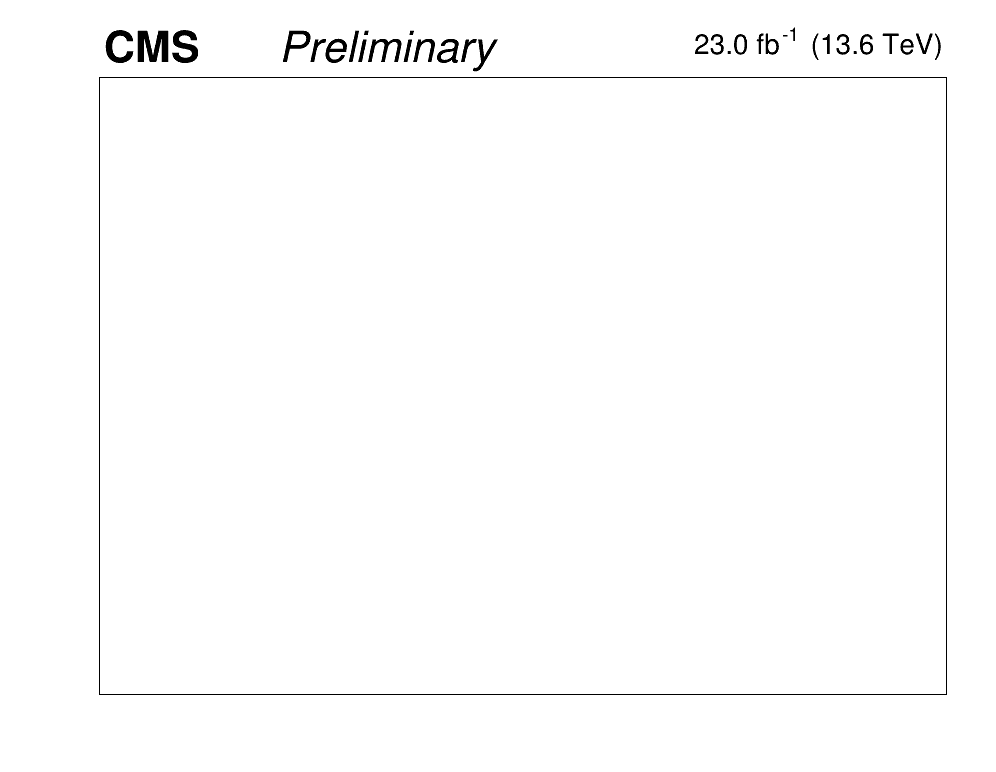

In [10]:
def plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs=False,do_idx_0=True):#(category,):

    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5-0.37,0.7,0.75-0.37,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    can.cd()
    phrase = "DT" if category==2 else 'CSC'
    plot_name = "Dt"  if category==2 else 'Csc'
    leg.SetHeader("CSC-"+phrase+"")

    scale = True
    
    for k in tree_keys:
    
        sel = (np.abs(dPhi_csc_csc[k]) > 1.2) & (np.abs(dPhi_csc_csc[k]) < 2.5) & (np.abs(dEta_csc_csc[k]) < 1.9)
        #cl_name = "2nd CSC, "
        if do_idx_0:
            tmp_var = var[k][sel][:,0]
        else:
            tmp_var = var[k][sel]
        if do_abs:
            tmp_var = np.abs(tmp_var)
        #var_axis = 'Csc Cluster DNN score'
        #var_label = 'CscClusterDNN'
        #bs = [100,0,1] 
        

        h[k] = create_TH1D(tmp_var.flatten(),title="",axis_title = [var_axis,'Events'], binning=bs)
        leg.AddEntry(h[k],cl_name+data_label[k],'PE' if 'data' in k else 'L')
        h[k].SetLineColor(colors[k])
        h[k].SetLineWidth(2)
        h[k].SetLineStyle(1)
        h[k].SetMarkerColor(colors[k])
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.2)
        h[k].SetMinimum(0.8)
        h[k].SetMaximum(1.e6)
        if h[k].Integral()>0 and scale:
            h[k].Scale(1./h[k].Integral())
            h[k].SetMinimum(0.0001)
            h[k].SetMaximum(1.)
        print(k)
        h[k].Draw('PE same' if 'data' in k else 'HISTO same')
        print(tmp_var)

    
    leg.Draw()
    can.SetRightMargin(0.05)
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

    # if setlog: 
    can.SetLogy()
    can.Draw()
    can.Print("plots/V1p19_"+plot_folder+"/"+var_label+plot_string+".pdf")
    can.Print("plots/V1p19_"+plot_folder+"/"+var_label+plot_string+".png")

    
cl_name = "2nd CSC, "    
var = cscClusterNStation
var_axis = 'Csc Cluster N Station'
var_label = 'CscClusterNStation'
bs = [4,0.5,4.5]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "    
var = tr_cscClusterNStation#[k][sel][:,0]
var_axis = 'Csc Cluster N Station'
var_label = 'FirstCscClusterNStation'
bs = [4,0.5,4.5]  
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterAvgStation#[k][sel][:,0]
var_axis = 'Csc Cluster Avg Station'
var_label = 'CscClusterAvgStation'
bs = [4,0.5,4.5]    
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterAvgStation#[k][sel][:,0]
var_axis = 'Csc Cluster Avg Station'
var_label = 'FirstCscClusterAvgStation'
bs = [4,0.5,4.5]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterEta#[k][sel][:,0]
var_axis = 'Csc Cluster Eta'
var_label = 'CscClusterEta'
bs = [100,0,3]
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterEta#[k][sel][:,0]
var_axis = 'Csc Cluster Eta'
var_label = 'FirstCscClusterEta'
bs = [100,0,3]
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterPhi#[k][sel][:,0]
var_axis = 'Csc Cluster Phi'
var_label = 'CscClusterPhi'
bs = [100,-3.2,3.2]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterPhi#[k][sel][:,0]
var_axis = 'Csc Cluster Phi'
var_label = 'FirstCscClusterPhi'
bs = [100,-3.2,3.2]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterZ#[k][sel][:,0]/100
var_axis = 'Csc Cluster |Z| (cm)'
var_label = 'CscClusterZ'
bs = [100,400,1200]
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterZ#[k][sel][:,0]/100
var_axis = 'Csc Cluster |Z| (cm)'
var_label = 'FirstCscClusterZ'
bs = [100,400,1200]
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterR#[k][sel][:,0]/100
var_axis = 'Csc Cluster R (cm)'
var_label = 'CscClusterR'
bs = [100,0,1000]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterR#[k][sel][:,0]/100
var_axis = 'Csc Cluster R (cm)'
var_label = 'FirstCscClusterR'
bs = [100,0,1000]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)


cl_name = ""
var = dEta_csc_csc#np.abs(dEta_csc_csc[k][sel])
var_axis = 'Csc Clusters #Delta#eta'
var_label = 'CscClusterDEta'
bs = [100,0,5]
do_abs=True
do_idx_0=False
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = ""
var = dt_csc_csc#np.abs(dt_csc_csc[k][sel])
var_axis = 'Csc Clusters #Delta t'
var_label = 'CscClusterDt'
bs = [100,0,50]     
do_abs=True
do_idx_0=False
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = ""
var = dR_csc_csc#np.abs(dR_csc_csc[k][sel])
var_axis = 'Csc Clusters #Delta R'
var_label = 'CscClusterDR'
bs = [100,0,6] 
do_abs=True
do_idx_0=False
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)


cl_name = ""
var = dPhi_csc_csc#np.abs(dPhi_csc_csc[k][sel & (np.abs(dPhi_csc_csc[k]) < 2.5)])
var_axis = 'Csc Clusters #Delta#varphi'
var_label = 'CscClusterDPhi'
bs = [100,0,3.2]   
do_abs=True
do_idx_0=False
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
   
cl_name = "2nd CSC, "
var = cscClusterMaxStation#[k][sel][:,0]
var_axis = 'Csc Cluster Max Station'
var_label = 'CscClusterMaxStation'
bs = [4,0.5,4.5]  
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "1st CSC, "
var = tr_cscClusterMaxStation#[k][sel][:,0]
var_axis = 'Csc Cluster Max Station'
var_label = 'FirstCscClusterMaxStation'
bs = [4,0.5,4.5] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "2nd CSC, "
var = cscClusterMet_dPhi#np.abs(cscClusterMet_dPhi[k][sel][:,0])
var_axis = 'Csc Cluster Met dPhi'
var_label = 'CscClusterMet_dPhi'
bs = [50,0,3.2]  
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "1st CSC, "
var = tr_cscClusterMet_dPhi#np.abs(tr_cscClusterMet_dPhi[k][sel][:,0])
var_axis = 'Csc Cluster Met dPhi'
var_label = 'FirstCscClusterMet_dPhi'
bs = [50,0,3.2] 
do_abs=True
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "2nd CSC, "
var = cscClusterSize#[k][sel][:,0]
var_axis = 'Csc Cluster Size'
var_label = 'CscClusterSize'
bs = [100,0,2000]     
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "1st CSC, "
var = tr_cscClusterSize#[k][sel][:,0]
var_axis = 'Csc Cluster Size'
var_label = 'FirstCscClusterSize'
bs = [100,0,2000] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "2nd CSC, "
var = cscClusterTime#[k][sel][:,0]
var_axis = 'Csc Cluster Time'
var_label = 'CscClusterTime'
bs = [100,-10,20]  
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "1st CSC, "
var = tr_cscClusterTime#[k][sel][:,0]
var_axis = 'Csc Cluster Time'
var_label = 'FirstCscClusterTime'
bs = [100,-50,50] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "2nd CSC, "
var = cscClusterTimeSpread#[k][sel][:,0]
var_axis = 'Csc Cluster TimeSpread'
var_label = 'CscClusterTimeSpread'
bs = [100,0,40]
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "1st CSC, "
var = tr_cscClusterTimeSpread#[k][sel][:,0]
var_axis = 'Csc Cluster TimeSpread'
var_label = 'FirstCscClusterTimeSpread'
bs = [100,0,40] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)
    
cl_name = "2nd CSC, "
var = cscClusterDNN#[k][sel][:,0]
var_axis = 'Csc Cluster DNN score'
var_label = 'CscClusterDNN'
bs = [100,0,1] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

cl_name = "1st CSC, "
var = tr_cscClusterDNN#[k][sel][:,0]
var_axis = 'Csc Cluster DNN score'
var_label = 'FirstCscClusterDNN'
bs = [100,0,1] 
do_abs=False
do_idx_0=True
plot_distr(category,tree_keys,cl_name,var,var_axis,var_label,bs,do_abs,do_idx_0)

In [11]:
! mkdir plots/V1p19_v6_ME1_old

mkdir: cannot create directory ‘plots/V1p19_v6_ME1_old’: File exists


# ABCD

In [12]:
PHI_MIN = 1.8
PHI_CUT = 2.
#PHI_MAX = 2.
PHI_MAX = 2.5

N_MIN = 50
N_MAX = 500000000
N_CUT = 200

n_ev = 5000

pre_cut = {}
a = {}
b = {}
c = {}
d = {}

In [13]:
def extrapolation(vec,min_x,max_x,nbins):
    h = create_TH1D(vec,title="",axis_title = ['',''], binning=[nbins,min_x,max_x])#,bin_list=True)
    #can = rt.TCanvas('c','c', 1000, 800)
    #can.cd()
    h.SetLineWidth(2)
    h.SetMarkerStyle(20)
    #f1 = rt.TF1("f1","[0]*x + [1]",min_x,max_x)
    #f1.SetParameter(0,-2)
    #f1.SetParameter(1,60)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",min_x,max_x)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    h.Fit('f1', 'LRSQ+', '', min_x,max_x)
    my_f1 = h.GetFunction("f1")            
    h.GetListOfFunctions().Remove(h.GetFunction("f1"))
    #h.Draw("PE")
    #h.GetXaxis().SetTitle("#Delta#varphi")
    ##h.SetTitle("High n hits region: "+str(N_CUT)+" < N hits < " + str(N_MAX))
    #my_f1.SetLineStyle(2)
    #my_f1.Draw('L same')
    #can.SetLogy()
    #can.Draw()
    #can.Print("test.pdf")
    #can.Print("test.png")
    return h, my_f1

In [14]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel,phi_th=2.2,n_th=150,do_b_extrapolation=False):
            
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])#high n, low phi
    #risk of unblinding D when phi gets too large. Try to predict it instead.
    if CUT2>=phi_th:
        low_d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<phi_th )])
        high_d_flat = (CUT2-phi_th)*low_d/( phi_th - MIN2 )
        d_pred = low_d+high_d_flat
        print("d\t d low\t d pred")
        print("%i\t %i\t  %.2f" % (d,low_d, d_pred))
        d = low_d+high_d_flat  
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#low n, high phi
    #risk of unblinding B when n hits gets too large. Try to predict it instead.
    if CUT1>=n_th and do_b_extrapolation:
        low_b_vec = var1[sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )]
        low_b = np.sum([sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )])
        h,my_f1 = extrapolation(low_b_vec,MIN1,CUT1,20)
        b_pred = my_f1.Integral(n_th,CUT1) + low_b
        print("b\t b pred")
        print("%i\t%.2f" % (b,b_pred))
        #high_b_flat = (CUT2-phi_th)*low_b/( phi_th - MIN2 )
        b = my_f1.Integral(n_th,CUT1) + low_b
        
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])#low n, low phi 
    #if CUT2>=phi_th:
    #    #low_c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<phi_th )])
    #    #high_c_flat = (CUT2-phi_th)*low_c/( phi_th - MIN2 )
    #    #c_pred = low_c+high_c_flat
    #    #print("c\t c low\t c pred")
    #    #print("%i\t %i\t  %.2f" % (c,low_c, c_pred))
    #    #c = low_c+high_c_flat  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#SR  
    pred = (b*d)/c
    unc_pred = (1./b if b>0 else 0 + 1./d if d>0 else 0 + 1./c if c>0 else 0)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = (norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [15]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )
    b = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 ) 
    c = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )  
    a = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )
    return a,b,c,d

In [16]:
def make_datacard_2tag(outDataCardsDir,modelName,  signal_rate, normalization, bkg_rate, observation, bkg_unc, bkg_unc_name, sig_unc, sig_unc_name,signal_region, prefix):
    a,b,c,d = bkg_rate[0], bkg_rate[1], bkg_rate[2], bkg_rate[3]
    nSig = len(signal_rate.keys())
    text_file = open(outDataCardsDir+modelName+".txt", "w")
    text_file.write('# signal norm {0} \n'.format(normalization))

    text_file.write('imax {0} \n'.format(4))
    text_file.write('jmax {0} \n'.format(nSig))
    text_file.write('kmax * \n')
    text_file.write('shapes * * FAKE \n')


    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t chA \t chB \t chC \t chD \n')
    text_file.write('observation \t {0:6.2f} \t {1:6.2f} \t {2:6.2f} \t {3:6.2f} \n'.format(observation[0],observation[1],observation[2],observation[3]))
    text_file.write('------------------------------ \n')
    text_file.write('bin '+'\t chA ' * (1+nSig) + '\t chB ' * (1+nSig) +'\t chC '*(1+nSig) +'\t chD '*(1+nSig) +'\n')
    process_name = '\t '+ (' \t ').join(list(signal_rate.keys())) + '\t bkg '
    text_file.write('process ' + process_name * 4 + '\n')
    process_number = '\t '+ (' \t ').join(list((np.arange(nSig)*-1).astype(str))) + '\t 1'
    text_file.write('process ' + process_number * 4 + '\n')
    rate_string = 'rate'
    for i in range(4):# 4 bins
        for k,v in signal_rate.items():
            rate_string +='\t {0:e} '.format(v[i])
        rate_string += '\t 1 '
    text_file.write(rate_string+'\n')
    text_file.write('------------------------------ \n')

    text_file.write(prefix+'A   rateParam       chA     bkg      (@0*@2/@1)                    '+prefix+'B,'+prefix+'C,'+prefix+'D \n')
    if b == 0: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, c*7))
    else: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, b*7))
    text_file.write(prefix+'C   rateParam       chC     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(c, c*7))
    if d == 0:text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, c*7))
    else: text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, d*7))


    #for k,v in signal_rate.items():
    #    text_file.write('norm rateParam * {0} 1  \n'.format(k))
        
    '''


  #### uncertainties ####
    for k,v in sig_unc.items():assert(len(sig_unc_name)==len(v))
    for i in range(len(sig_unc_name)):
        if 'mc_stats' in sig_unc_name[i]:
            for j, bin in enumerate(['A', 'B', 'C', 'D']):#bin
                    for l, k in enumerate(sig_unc.keys()): #channels
                        before = (len(sig_unc.keys())+1)*j+l
                        after = (len(sig_unc.keys())+1)*4-before-1
                        if sig_unc[k][i][j] > 0.0: text_file.write(sig_unc_name[i]+'_'+k+'_'+bin+' \t gmN ' +str(int(sig_unc[k][i][j]))+ '  '+'\t -  '*before + str(signal_rate[k][j]/int(sig_unc[k][i][j])) + '\t - '*after +'\n')

        else:

            unc_text = sig_unc_name[i]+' \t lnN'
            if len(sig_unc[list(sig_unc.keys())[0]][i])==4:#symmetric uncertainties
                for j in range(4):#bin
                    for k,v in sig_unc.items():
                        if v[i][j] == 0.0:unc_text += ' \t -'
                        else: unc_text += ' \t '+str(v[i][j]+1)
                    unc_text += '\t - '
            else:#asymmetric
                for j in range(4):#bin A, B, C, D
                    for k,v in sig_unc.items():
                        if  v[i][j] == 0.0 and v[i][j+4] == 0.0: unc_text += ' \t -'
                        else:unc_text += ' \t {0}/{1}'.format(1-v[i][j],1+v[i][j+4])
                    unc_text += '\t -'
            text_file.write(unc_text + ' \n')
    '''
    for i in range(len(bkg_unc_name)):
        bkg_unc_text = bkg_unc_name[i] + ' \t lnN ' + '\t - '*(4*nSig+3) + '\t ' + str(1+bkg_unc[i]) + ' \n'
        text_file.write(bkg_unc_text)
    

    text_file.close()


In [17]:
#0, 0.5, 0.8, 1, 1.1, 1.2
dr_min_list = [0.5]#[0.9]#[1.9]
phi_min_scan_list = [0,0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]

phi_min_scan_list = [1.1]
phi_cut_scan_list = np.linspace(1.5,3.1,64+1)#[1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,3.]
phi_cut_scan_list = np.linspace(1.5,3.1,32+1)

#phi_cut_scan_list = [2.85]
N_CUT = 240

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for phi_cut_scan in phi_cut_scan_list:
    signal_rate[phi_cut_scan] = {}

print('k\t phi\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,0]
        t_var = cscClusterTime[k][:,0]
        t_spread_var = cscClusterTimeSpread[k][:,0]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) #sel_ev[k]  &  & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        for phi_cut_scan in phi_cut_scan_list:
            if phi_cut_scan<=PHI_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                print("%s\t %.2f\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,phi_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))*lumi/NEvents['signal']*48.58
                b[k] = (np.sum(weight[k][ mb ]))*lumi/NEvents['signal']*48.58
                c[k] = (np.sum(weight[k][ mc ]))*lumi/NEvents['signal']*48.58
                d[k] = (np.sum(weight[k][ md ]))*lumi/NEvents['signal']*48.58
                print(k,phi_cut_scan,a[k],b[k],c[k],d[k], a[k]+b[k]+c[k]+d[k])
                signal_rate[phi_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



k	 phi	 B	 C	 D	 A	 pred		 zval	 perc
data	 1.85	 283	 25	 5	 30	 56.60 +- 3.36	 3.64	 88.67
data	 1.90	 265	 43	 7	 28	 43.14 +- 2.65	 2.35	 54.07
data	 1.95	 243	 65	 8	 27	 29.91 +- 1.92	 0.56	 10.77
data	 2.00	 219	 89	 11	 24	 27.07 +- 1.83	 0.61	 12.78
data	 2.05	 198	 110	 14	 21	 25.20 +- 1.79	 0.88	 20.00
data	 2.10	 170	 138	 17	 18	 20.94 +- 1.61	 0.70	 16.34
data	 2.15	 156	 152	 20	 15	 20.53 +- 1.64	 1.28	 36.84
d	 d low	 d pred
21	 21	  21.00
data	 2.20	 130	 178	 21	 14	 15.34 +- 1.35	 0.40	 9.55
d	 d low	 d pred
25	 21	  23.62
data	 2.25	 107	 201	 23	 10	 12.58 +- 1.22	 0.80	 25.76
d	 d low	 d pred
26	 21	  26.25
data	 2.30	 86	 222	 26	 9	 10.17 +- 1.10	 0.45	 12.99
d	 d low	 d pred
29	 21	  28.87
data	 2.35	 61	 247	 28	 6	 7.13 +- 0.91	 0.53	 18.85
d	 d low	 d pred
32	 21	  31.50
data	 2.40	 44	 264	 31	 3	 5.25 +- 0.79	 1.17	 75.00
d	 d low	 d pred
32	 21	  34.12
data	 2.45	 16	 292	 34	 3	 1.87 +- 0.47	 -0.55	 -37.67
d	 d low	 d pred
35	 21	  36.75
data	 2.50	 0	

/afs/desy.de/user/l/lbenato/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


data	 2.60	 0	 370	 41	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
43	 21	  44.62
data	 2.65	 0	 392	 44	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
43	 21	  47.25
data	 2.70	 0	 417	 47	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
46	 21	  49.87
data	 2.75	 0	 440	 49	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
50	 21	  52.50
data	 2.80	 0	 469	 52	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
53	 21	  55.12
data	 2.85	 0	 497	 55	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
56	 21	  57.75
data	 2.90	 0	 529	 57	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
56	 21	  60.37
data	 2.95	 0	 554	 60	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
57	 21	  63.00
data	 3.00	 0	 578	 62	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
59	 21	  65.62
data	 3.05	 0	 612	 65	 0	 0.00 +- 0.00	 inf	 nan
d	 d low	 d pred
60	 21	  68.25
data	 3.10	 0	 649	 68	 0	 0.00 +- 0.00	 inf	 nan
signal 1.85 87.59305061337595 100.2789483423262 3.020449623228161 6.040899644379056 196.9333482233094
signal 1.9 84.57260059222506

In [18]:
#print(tree_keys)
    
denS = signal_gen_yield
denD = np.sum(all_weight['data'])
ks = 'signal'
kd = 'data'
L=lumi/NEvents['signal']*48.58
#L=lumi/1000.
print("Selection \t\t\t S \t\t Eff. S(%) \t B \t\t Eff. B(%) \t S/sqrt(B) ")
print("%s\t\t\t\t %.2f %.2f\t\t %.2f\t %.2f\t\t %.2f" % 
            ("No cuts",
                np.sum(all_weight[ks])*L, (100*np.sum(all_weight[ks])*L)/denS, 
                np.sum(all_weight[kd])  , (100*np.sum(all_weight[kd]))/denD,
                (np.sum(all_weight[ks]))/(np.sqrt(np.sum(all_weight[kd])))
              )
             )
                                             
print("%s\t\t\t\t %.2f %.3f \t %.2f\t %.3f\t\t %.2f" % 
            (">=1 CSC", 
               (np.sum(n_1CSC[ks])*L) , (100*np.sum(n_1CSC[ks])*L)/denS,
               (np.sum(n_1CSC[kd])) , (100*np.sum(n_1CSC[kd]))/denD,
               (np.sum(n_1CSC[ks]))/np.sqrt(np.sum(n_1CSC[kd]))
             )
            )
#print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
#      (">=1 CSC (ME1 old)", 
#       (np.sum(n_1CSC_ME1_old[ks])*L) , (100*np.sum(n_1CSC_ME1_old[ks])*L)/denS,
#       (np.sum(n_1CSC_ME1_old[kd])) , (100*np.sum(n_1CSC_ME1_old[kd]))/denD,
#       (np.sum(n_1CSC_ME1_old[ks]))/(np.sqrt(np.sum(n_1CSC_ME1_old[kd]))),
#      )
#     )
print("%s\t\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=1 CSC (ME1)", 
       (np.sum(n_1CSC_ME1[ks])*L) , (100*np.sum(n_1CSC_ME1[ks])*L)/denS,
       (np.sum(n_1CSC_ME1[kd])) , (100*np.sum(n_1CSC_ME1[kd]))/denD,
       (np.sum(n_1CSC_ME1[ks]))/(np.sqrt(np.sum(n_1CSC_ME1[kd]))),
      )
     )

#print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
#      (">=1 CSC (ME1+L1)", 
#       (np.sum(n_1CSC_ME1_plateau[ks])*L) , (100*np.sum(n_1CSC_ME1_plateau[ks])*L)/denS,
#       (np.sum(n_1CSC_ME1_plateau[kd])) , (100*np.sum(n_1CSC_ME1_plateau[kd]))/denD,
#       (np.sum(n_1CSC_ME1_plateau[ks]))/(np.sqrt(np.sum(n_1CSC_ME1_plateau[kd]))),
#      )
#     )
    
#print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
#      (">=1 CSC (ME1+L1+0L)", 
#       (np.sum(n_1CSC_ME1_plateau_0lep[ks])*L) , (100*np.sum(n_1CSC_ME1_plateau_0lep[ks])*L)/denS,
#       (np.sum(n_1CSC_ME1_plateau_0lep[kd])) , (100*np.sum(n_1CSC_ME1_plateau_0lep[kd]))/denD,
#       (np.sum(n_1CSC_ME1_plateau_0lep[ks]))/(np.sqrt(np.sum(n_1CSC_ME1_plateau_0lep[kd]))),
#      )
#     )
print("************************************************************")
#print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
#      (">=2 CSC (ME1 old)", 
#       (np.sum(n_2CSC_ME1_old[ks])*L) , (100*np.sum(n_2CSC_ME1_old[ks])*L)/denS,
#       (np.sum(n_2CSC_ME1_old[kd])) , (100*np.sum(n_2CSC_ME1_old[kd]))/denD,
#       (np.sum(n_2CSC_ME1_old[ks]))/(np.sqrt(np.sum(n_2CSC_ME1_old[kd]))),
#      )
#     )
print("%s\t\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=2 CSC (ME1)", 
       (np.sum(n_2CSC_ME1[ks])*L) , (100*np.sum(n_2CSC_ME1[ks])*L)/denS,
       (np.sum(n_2CSC_ME1[kd])) , (100*np.sum(n_2CSC_ME1[kd]))/denD,
       (np.sum(n_2CSC_ME1[ks]))/(np.sqrt(np.sum(n_2CSC_ME1[kd]))),
      )
     )
    
print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=2 CSC (ME1+L1)", 
       (np.sum(n_2CSC_ME1_plateau[ks])*L) ,  (100*np.sum(n_2CSC_ME1_plateau[ks])*L)/denS,
       (np.sum(n_2CSC_ME1_plateau[kd])) ,  (100*np.sum(n_2CSC_ME1_plateau[kd]))/denD,
       (np.sum(n_2CSC_ME1_plateau[ks]))/(np.sqrt(np.sum(n_2CSC_ME1_plateau[kd]))),
      )
     )


print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=2 CSC (ME1+L1+0L)", 
       (np.sum(n_2CSC_ME1_plateau_0lep[ks])*L) ,  (100*np.sum(n_2CSC_ME1_plateau_0lep[ks])*L)/denS,
       (np.sum(n_2CSC_ME1_plateau_0lep[kd])) ,  (100*np.sum(n_2CSC_ME1_plateau_0lep[kd]))/denD,
       (np.sum(n_2CSC_ME1_plateau_0lep[ks]))/(np.sqrt(np.sum(n_2CSC_ME1_plateau_0lep[kd]))),
      )
     )
print("%s\t\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=2 CSC (ME1+L1+0L+HLT)", 
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt[ks])*L) ,  (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt[ks])*L)/denS,
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt[kd])) ,  (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt[kd]))/denD,
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt[ks]))/(np.sqrt(np.sum(n_2CSC_ME1_plateau_0lep_hlt[kd]))),
      )
     )
    
print("%s\t %.2f\t %.3f\t\t %.2f\t %.3f\t\t %.2f" % 
      (">=2 CSC (ME1+L1+0L+HLT+dPhi)", 
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[ks])*L) , (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[ks])*L)/denS,
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[kd])) , (100*np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[kd]))/denD,
       (np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[ks]))/(np.sqrt(np.sum(n_2CSC_ME1_plateau_0lep_hlt_dphi[kd]))),
      )
     )
    
    
sel_s = (  np.abs(dPhi_csc_csc[ks])>1.8 )
n_tag_s = weight[ks][sel_s][ (tr_cscClusterDNN[ks][sel_s][:,0]>0.7) & (cscClusterDNN[ks][sel_s][:,0]>0.7) ].sum()
sel_d = (  np.abs(dPhi_csc_csc[kd])>1.8) & (np.abs(dPhi_csc_csc[kd])<2.5)
n_tag_d = weight[kd][sel_d][ (tr_cscClusterDNN[kd][sel_d][:,0]>0.7) & (cscClusterDNN[kd][sel_d][:,0]>0.7) ].sum()

print("%s\t %.2f\t %.4f\t\t %.2f\t\t %.4f\t\t %.2f" % 
      (">=2 CSC 2 tagged DNN>0.7", 
       n_tag_s*L , (100*n_tag_s*L)/denS,
       n_tag_d , (100*n_tag_d)/denD,
       n_tag_s/np.sqrt(n_tag_d),
     )
     )

    
sel_s = (  np.abs(dPhi_csc_csc[ks])>1.8 )
n_tag_s = weight[ks][sel_s][ (tr_cscClusterDNN[ks][sel_s][:,0]>0.8) & (cscClusterDNN[ks][sel_s][:,0]>0.8) ].sum()
sel_d = (  np.abs(dPhi_csc_csc[kd])>1.8) & (np.abs(dPhi_csc_csc[kd])<2.5)
n_tag_d = weight[kd][sel_d][ (tr_cscClusterDNN[kd][sel_d][:,0]>0.8) & (cscClusterDNN[kd][sel_d][:,0]>0.8) ].sum()

print("%s\t %.2f\t %.4f\t\t %.2f\t\t %.4f\t\t %.2f" % 
      (">=2 CSC 2 tagged DNN>0.8", 
       n_tag_s*L , (100*n_tag_s*L)/denS,
       n_tag_d , (100*n_tag_d)/denD,
       n_tag_s/np.sqrt(n_tag_d),
     )
     )

sel_s = (  np.abs(dPhi_csc_csc[ks])>1.8 )
n_tag_s = weight[ks][sel_s][ (tr_cscClusterDNN[ks][sel_s][:,0]>0.9) & (cscClusterDNN[ks][sel_s][:,0]>0.9) ].sum()
sel_d = (  np.abs(dPhi_csc_csc[kd])>1.8) & (np.abs(dPhi_csc_csc[kd])<2.5)
n_tag_d = weight[kd][sel_d][ (tr_cscClusterDNN[kd][sel_d][:,0]>0.9) & (cscClusterDNN[kd][sel_d][:,0]>0.9) ].sum()

print("%s\t %.2f\t %.4f\t\t %.2f\t\t %.4f\t\t %.2f" % 
      (">=2 CSC 2 tagged DNN>0.9", 
       n_tag_s*L , (100*n_tag_s*L)/denS,
       n_tag_d , (100*n_tag_d)/denD,
       n_tag_s/np.sqrt(n_tag_d),
     )
     )

Selection 			 S 		 Eff. S(%) 	 B 		 Eff. B(%) 	 S/sqrt(B) 
No cuts				 1118334.97 100.00		 15508012.00	 100.00		 10889.68
>=1 CSC				 227016.98 20.300 	 15066429.00	 97.153		 2242.72
>=1 CSC (ME1)			 100069.30	 8.948		 13205931.00	 85.156		 1055.94
************************************************************
>=2 CSC (ME1)			 2580.67	 0.231		 143151.00	 0.923		 261.55
>=2 CSC (ME1+L1)		 1547.68	 0.138		 86693.00	 0.559		 201.56
>=2 CSC (ME1+L1+0L)		 1537.41	 0.137		 86133.00	 0.555		 200.88
>=2 CSC (ME1+L1+0L+HLT)		 1440.15	 0.129		 9006.00	 0.058		 581.92
>=2 CSC (ME1+L1+0L+HLT+dPhi)	 1296.38	 0.116		 1302.00	 0.008		 1377.68
>=2 CSC 2 tagged DNN>0.7	 718.26	 0.0642		 27.00		 0.0002		 5300.57
>=2 CSC 2 tagged DNN>0.8	 601.07	 0.0537		 19.00		 0.0001		 5287.73
>=2 CSC 2 tagged DNN>0.9	 401.72	 0.0359		 8.00		 0.0001		 5446.28
